In [1]:
%pip install torchinfo
%pip install captum
%pip install captum.attr
%pip install split-folders
%pip install mlflow azureml-mlflow
%pip install azureml
%pip install azureml.core
%pip install azureml.mlflow
%pip install torch
%pip install torch.nn.functional
%pip install torch.utils.data.dataloader
%pip install torchvision.transforms
%pip install torchvision.models
%pip install torchvision.datasets
%pip install torchinfo
%pip install torchvision
%pip install torchvision.utils
%pip install lime

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement captum.attr (from versions: none)
ERROR: No matching distribution found for captum.attr
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement torch.nn.functional (from versions: none)
ERROR: No matching distribution found for torch.nn.functional
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find 

In [2]:
import logging
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import mlflow
import azureml.core
from azureml.core import Workspace, Dataset, Experiment, Run, Model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchinfo import summary
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

import captum
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
import torchvision.transforms as T
from captum.attr._core.lime import get_exp_kernel_similarity_function

import shutil
import json
import splitfolders
from textwrap import wrap
from datetime import datetime
from utils.demoutils import train, plot_learning_curve, to_categorical, predict_loader, inverse_normalize, plot_confusion_matrix

from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

In [3]:
import logging
logging.basicConfig(filename='experiment.log', filemode = 'w', format='%(levelname)s: %(message)s')
logger=logging.getLogger()
logger.setLevel(logging.INFO)

def record(entry, console=True, logfile=True):
    ''' log entry to console and/or logfile file '''
    logentry = f'{datetime.now().strftime("%d/%m/%Y %H:%M")} : {entry}' 
    if console:
        print(logentry)
    if logfile:
        logger.info(logentry)

In [4]:
import azureml.core
ws = azureml.core.Workspace.from_config()
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
print(ws.get_mlflow_tracking_uri())

record(f'Ready to use Azure ML {azureml.core.VERSION} and MLflow {mlflow.__version__} with Workspace {ws.name}')

azureml://northeurope.api.azureml.ms/mlflow/v2.0/subscriptions/759daac4-4dc8-4347-8b9f-0fabb64cfd1d/resourceGroups/medical-imaging/providers/Microsoft.MachineLearningServices/workspaces/medical-imaging?
27/02/2023 12:14 : Ready to use Azure ML 1.48.0 and MLflow 2.1.1 with Workspace medical-imaging


In [5]:
# Global settings and  hyperparameters
random_seed = 1
experiment_name = 'brain-tumor-classification'
base_dir = '/home/azureuser/brain-tumor'
base_dir_tvt = '/home/azureuser/brain-tumor-tvt'
model_path = './models/brain-tumor-classification.pth'

train_val_test_split = (0.8, 0.1, 0.1)
img_height, img_width, channels = 224, 224, 3 # 256, 256, 3
rgb_means = (0.485, 0.456, 0.406) # (0.1781, 0.1781, 0.1781)
rgb_stds = (0.229, 0.224, 0.225) # (0.1936, 0.1936, 0.1936) 
batch_size = 32
learning_rate = 5.0e-5
epochs = 15
classCount = 4

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
if device.type == 'cuda':
    record(f'{torch.cuda.device_count()} instance(s) of {torch.cuda.get_device_name(0)} GPU available')

27/02/2023 12:14 : 1 instance(s) of Tesla K80 GPU available


In [6]:
#print(experiment.name)
#mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
#mlflow.set_experiment(experiment.name)

In [6]:
# Submit experiment run
experiment = Experiment(ws, experiment_name)
mlflow.set_experiment(experiment.name)

# make MLFlow run accessible for AML SDK
mlflow.start_run()
run_id = mlflow.active_run().info.run_id
amlrun = Run(experiment, run_id)

record(f'Experiment run with id {run_id} started.')

27/02/2023 12:14 : Experiment run with id 97940257-1be8-4b84-8d4c-28a722fcbf9b started.


In [8]:
import os
import urllib
from zipfile import ZipFile

test_file = './test.txt'

with open(test_file, 'w') as fp:
    print("Done")
    fp.write('Test file created')

Done


In [9]:
import os
import urllib
from zipfile import ZipFile

data_file = '../datasets/brain-tumor-complete.zip'
data_folder = '../datasets'

# extract files
with ZipFile(data_file, 'r') as zip:
    print('extracting files...')
    zip.extractall(data_folder)
    print('done')
    
# delete zip file
# os.remove(data_file)

extracting files...
done


In [7]:
pip install azureml.dataprep

Note: you may need to restart the kernel to use updated packages.


In [8]:
from azureml.core import Workspace, Datastore, Dataset
from azureml.data.datapath import DataPath

# Upload data to AzureML Datastore
ds = ws.get_default_datastore()
ds = Dataset.File.upload_directory(src_dir='../datasets/brain_tumor_all',
           target=DataPath(ds, 'brain-tumor-complete'),
           show_progress=False, overwrite=True)

# Register file dataset with AzureML
ds = ds.register(workspace=ws, name='brain-tumor-complete', description='MRI images for brain tumor classification')

record(f'Dataset {ds.name} registered.')

27/02/2023 12:15 : Dataset brain-tumor-complete registered.


In [9]:
aml_dataset = Dataset.get_by_name(ws, name='brain-tumor-complete', version='latest')

#shutil.rmtree(base_dir) # delete files from previous experiment with potentially different dataset
filelist = aml_dataset.download(target_path=base_dir, overwrite=True)
splitfolders.ratio(base_dir, base_dir_tvt, random_seed, ratio=train_val_test_split)

record(f'{len(filelist)} files downloaded to {base_dir_tvt}')

Copying files: 3264 files [00:09, 335.74 files/s]


In [10]:
transform_train = T.Compose([T.Resize((img_height+20, img_width+20)), 
                             T.RandomRotation(degrees = 7),
                             T.CenterCrop((img_height, img_width)),
                             T.RandomHorizontalFlip(p = 0.5),
                             T.ToTensor(),
                             T.Normalize(rgb_means, rgb_stds)    
                            ])

transform_val = T.Compose([T.Resize((img_height, img_width)),
                           T.CenterCrop((img_height, img_width)),
                           T.ToTensor(),   
                           T.Normalize(rgb_means, rgb_stds)    
                          ])

train_ds = ImageFolder(os.path.join(base_dir_tvt, 'train'), transform_train)
val_ds = ImageFolder(os.path.join(base_dir_tvt, 'val'), transform_val)
test_ds = ImageFolder(os.path.join(base_dir_tvt, 'test'), transform_val)

train_ldr = DataLoader(train_ds, batch_size, shuffle = True)
val_ldr = DataLoader(val_ds, batch_size)
test_ldr = DataLoader(test_ds, batch_size)

img_transforms = ' '.join(map(str, train_ds.transform.__dict__['transforms']))

record(f'Image transformations: {img_transforms}')
record(f'Dataset classes: {train_ds.classes} with {len(train_ds)} training, {len(val_ds)} val. and {len(test_ds)} test images.')

27/02/2023 12:16 : Image transformations: Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=None) RandomRotation(degrees=[-7.0, 7.0], interpolation=nearest, expand=False, fill=0) CenterCrop(size=(224, 224)) RandomHorizontalFlip(p=0.5) ToTensor() Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
27/02/2023 12:16 : Dataset classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'] with 2609 training, 325 val. and 330 test images.


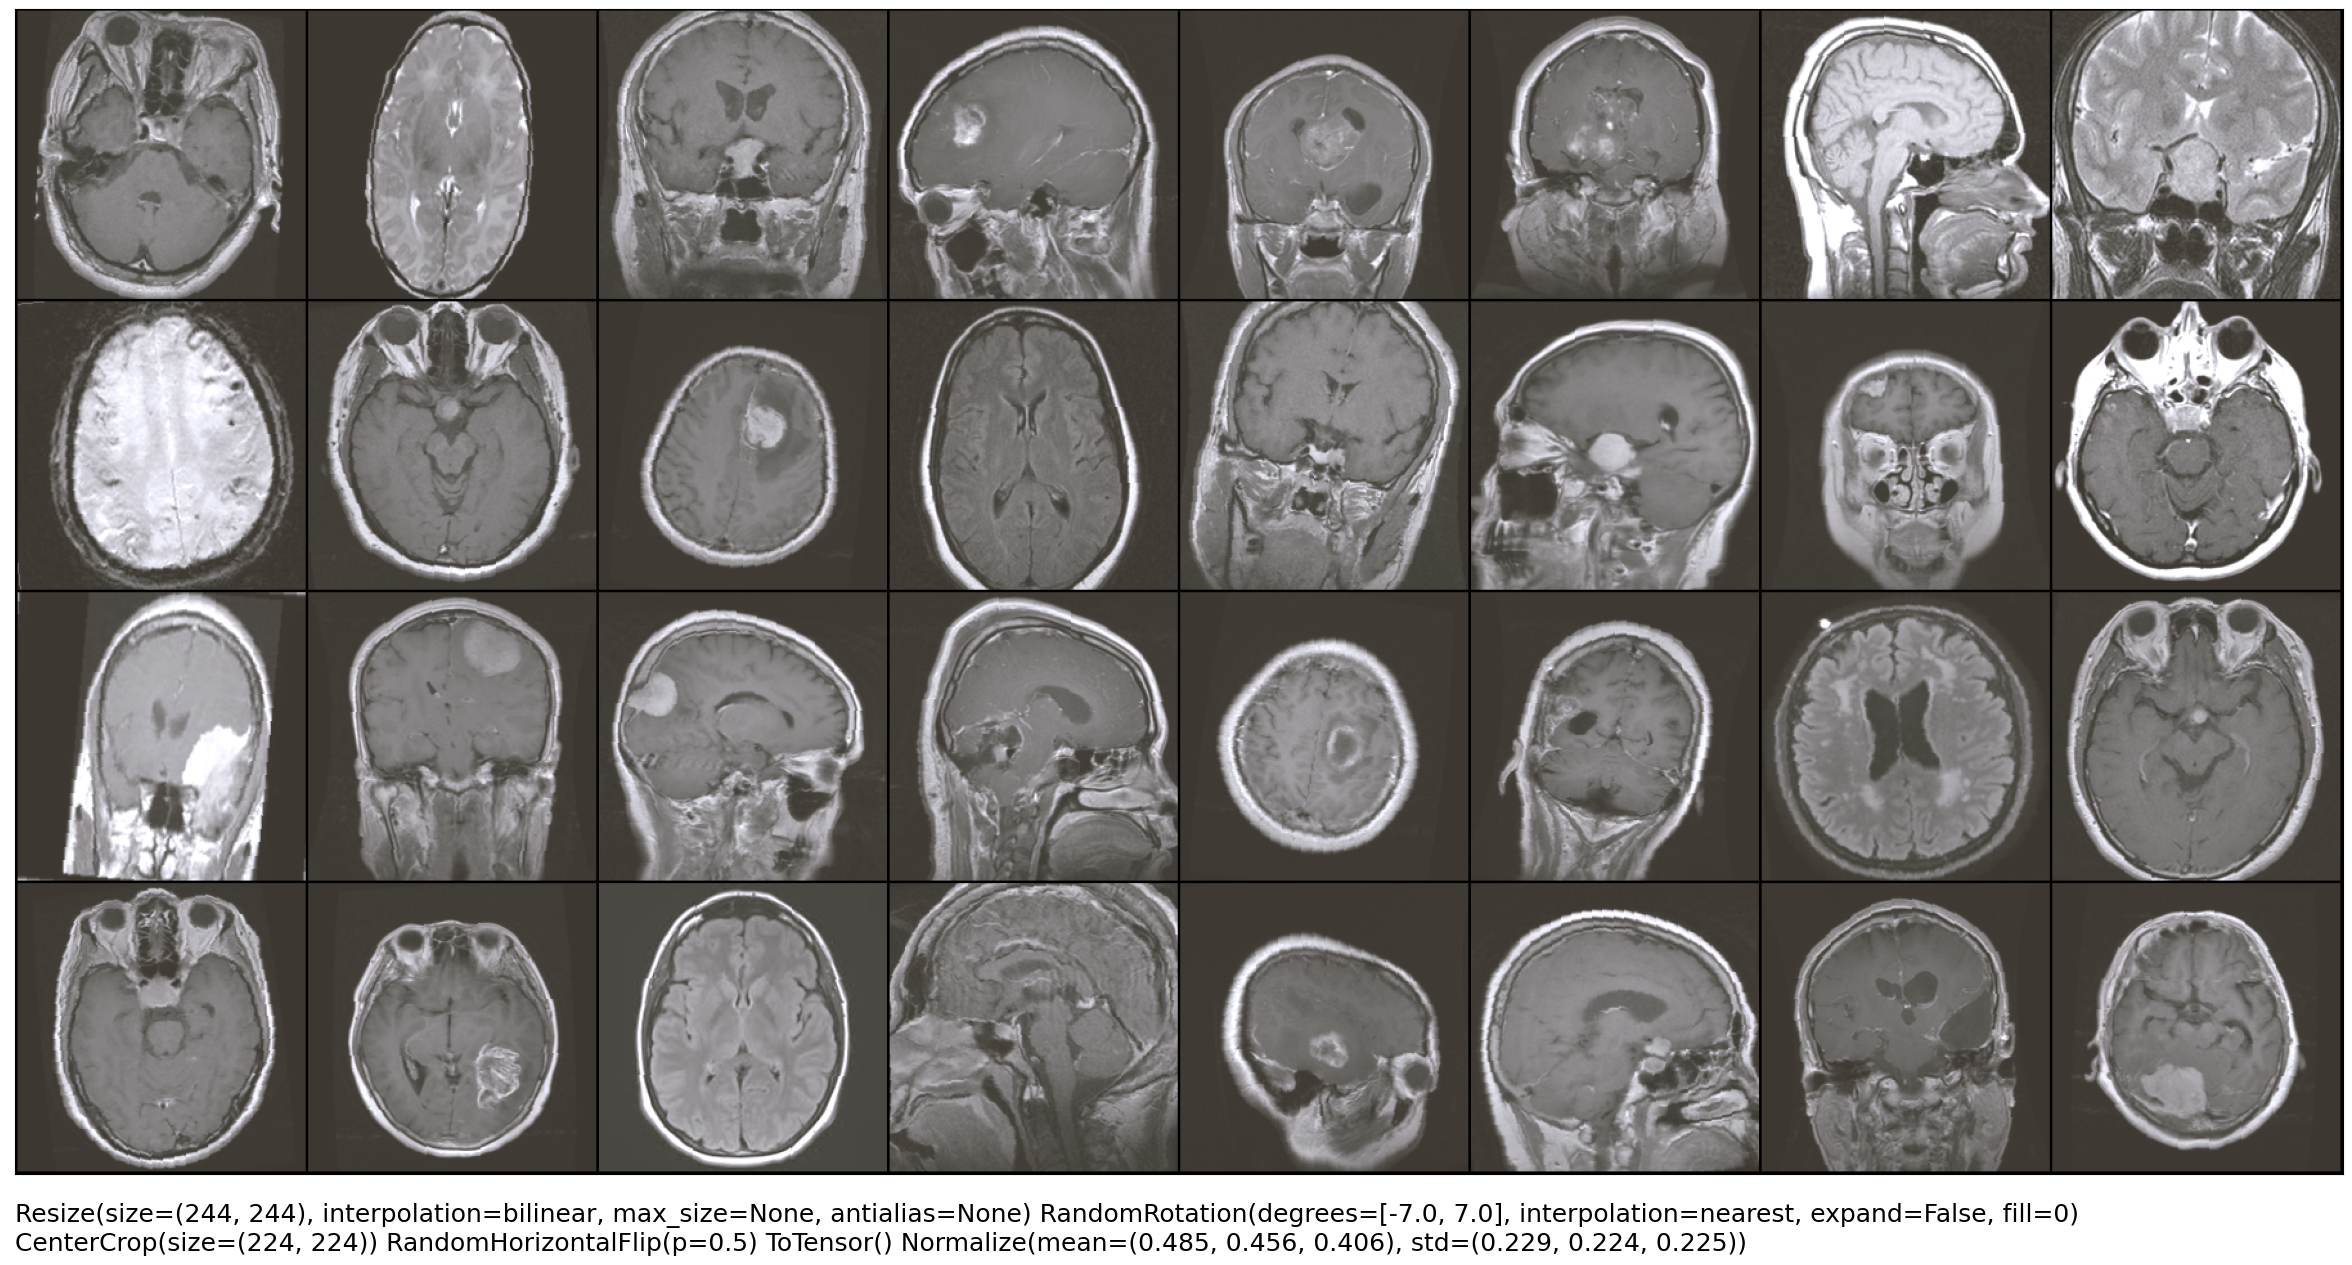

In [11]:
images, labels = next(iter(train_ldr))
fig, ax = plt.subplots(figsize=(24, 12))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(inverse_normalize(images), nrow = 8).permute(1, 2, 0))
plt.tight_layout()

plt.annotate('\n'.join(wrap(img_transforms,160)), (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=18)

# record images to run history
preprocessed_samples = plt.gcf()
try:
    mlflow.log_figure(preprocessed_samples, 'sample-images.png')
except Exception as e: print(e)

plt.show()

In [12]:
def get_squeezenet():
    #model = models.squeezenet(pretrained=True)
    model = models.squeezenet1_1(pretrained=True)
    # model.features[0] = 4
    model.classifier[1] = nn.Conv2d(512, classCount, kernel_size=(1,1), stride=(1,1))
    model.num_classes = classCount
    # Adjust last layer to 4 target classes
    # num_ftrs = model.fc.in_features
    # model.fc = torch.nn.Linear(4, len(train_ds.classes))
    return model

model = get_squeezenet().to(device)

In [13]:
model_summary = summary(model, input_size=(1,channels, img_height, img_width))
print(str(model_summary))

try: mlflow.log_text(str(model_summary), 'model-summary.txt')
except Exception as e: print(e)

Layer (type:depth-idx)                   Output Shape              Param #
SqueezeNet                               [1, 4]                    --
├─Sequential: 1-1                        [1, 512, 13, 13]          --
│    └─Conv2d: 2-1                       [1, 64, 111, 111]         1,792
│    └─ReLU: 2-2                         [1, 64, 111, 111]         --
│    └─MaxPool2d: 2-3                    [1, 64, 55, 55]           --
│    └─Fire: 2-4                         [1, 128, 55, 55]          --
│    │    └─Conv2d: 3-1                  [1, 16, 55, 55]           1,040
│    │    └─ReLU: 3-2                    [1, 16, 55, 55]           --
│    │    └─Conv2d: 3-3                  [1, 64, 55, 55]           1,088
│    │    └─ReLU: 3-4                    [1, 64, 55, 55]           --
│    │    └─Conv2d: 3-5                  [1, 64, 55, 55]           9,280
│    │    └─ReLU: 3-6                    [1, 64, 55, 55]           --
│    └─Fire: 2-5                         [1, 128, 55, 55]          --
│  

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

mlflow.log_params({'Architecture' : 'SqueezeNet',
                   'Transfer Learning' : 'Yes',
                   'Epochs' : epochs,
                   'Optim' : str(optimizer).split()[0],
                   'LR' : learning_rate,
                   'Batch size' : train_ldr.batch_size,
                   'Train size' : len(train_ds),
                   'Preprocess' : img_transforms[:255]})

In [15]:
torch.manual_seed(random_seed)
total_time_sec, time_per_epoch_sec, best_model, history = train(model = model,
                             device=device,
                             optimizer = optimizer,
                             loss_fn = torch.nn.CrossEntropyLoss(),
                             train_dl = train_ldr,
                             val_dl = val_ldr,
                             epochs = epochs)

record('Training finished after {:.1f} min ({:.1f} sec per epoch) with best validation accuracy of {:.4f}'
.format(total_time_sec/60, time_per_epoch_sec, max(history['val_acc'])))

train() called: model=SqueezeNet, opt=Adam(lr=0.000050), epochs=15, device=cuda

Epoch   1/ 15, train loss:  0.86, train acc:  0.66, val loss:  0.56, val acc:  0.78 <- best epoch so far
Epoch   2/ 15, train loss:  0.53, train acc:  0.80, val loss:  0.44, val acc:  0.82 <- best epoch so far
Epoch   3/ 15, train loss:  0.45, train acc:  0.84, val loss:  0.39, val acc:  0.86 <- best epoch so far
Epoch   4/ 15, train loss:  0.39, train acc:  0.86, val loss:  0.34, val acc:  0.87 <- best epoch so far
Epoch   5/ 15, train loss:  0.34, train acc:  0.88, val loss:  0.30, val acc:  0.88 <- best epoch so far
Epoch   6/ 15, train loss:  0.30, train acc:  0.90, val loss:  0.32, val acc:  0.89 <- best epoch so far
Epoch   7/ 15, train loss:  0.27, train acc:  0.90, val loss:  0.34, val acc:  0.87 
Epoch   8/ 15, train loss:  0.27, train acc:  0.91, val loss:  0.27, val acc:  0.89 
Epoch   9/ 15, train loss:  0.23, train acc:  0.91, val loss:  0.46, val acc:  0.84 
Epoch  10/ 15, train loss:  0.22, 

HTTPSConnectionPool(host='northeurope.api.azureml.ms', port=443): Read timed out. (read timeout=300)


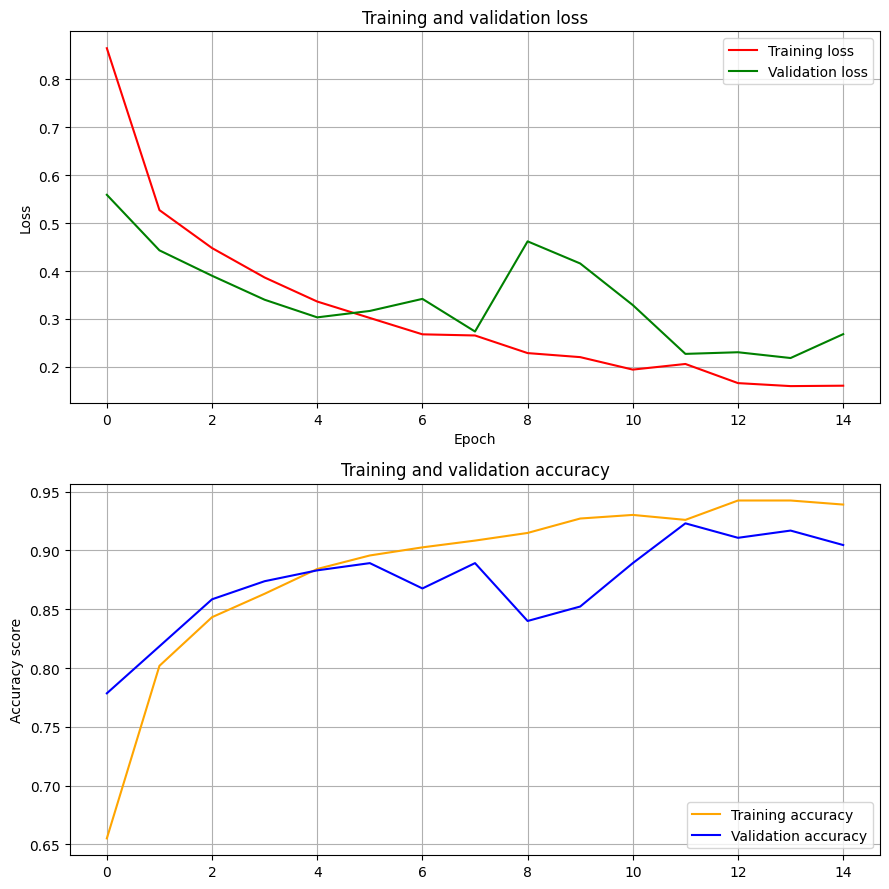

In [16]:
fig = plot_learning_curve(history)
try:
    mlflow.log_figure(fig, 'learning-curves.png')
except Exception as e: print(e)
plt.show()

In [17]:
y_true, y_pred, y_probs = predict_loader(model, test_ldr, device)

y_true = y_true.cpu()
y_pred = y_pred.cpu()
y_probs = y_probs.cpu()

y_true_oh = to_categorical(y_true, num_classes = len(train_ds.classes))
y_pred_oh = to_categorical(y_pred, num_classes = len(train_ds.classes))

# accuracy_sc = accuracy_score(y_true, y_pred)
# roc_auc_sc = roc_auc_score(y_true_oh, y_probs)

print(classification_report(y_true, y_pred, target_names = train_ds.classes))
#try:
#    mlflow.log_metrics({'Test Accuracy' : accuracy_sc, 'Test AUC' : roc_auc_sc})
#except Exception as e: print(e)
#record(f'Model evaluated on test set with accuracy of {accuracy_sc:.4f} and AUC score of {roc_auc_sc:.4f}')

                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.91      0.89        94
meningioma_tumor       0.90      0.93      0.91        95
        no_tumor       0.95      0.84      0.89        50
 pituitary_tumor       0.98      0.96      0.97        91

        accuracy                           0.92       330
       macro avg       0.92      0.91      0.92       330
    weighted avg       0.92      0.92      0.92       330



In [21]:
#roc_auc_score(y_true_oh, y_probs)

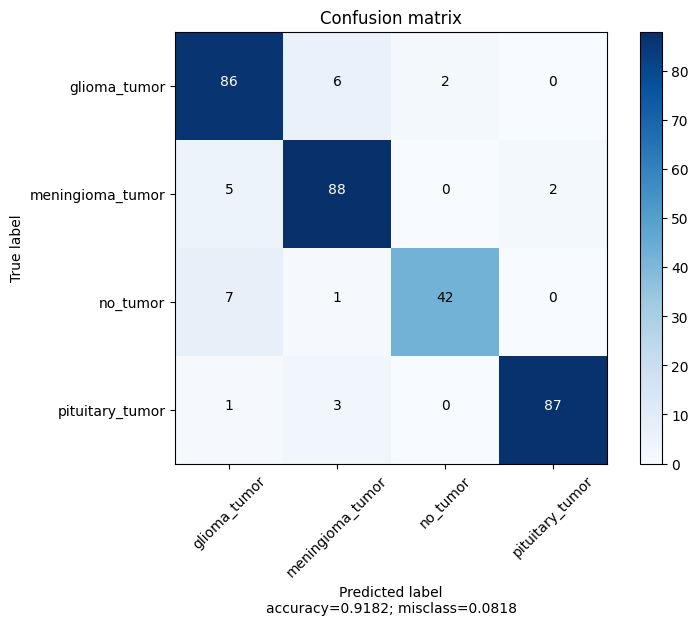

In [18]:
conf = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf, train_ds.classes, normalize=False)

# Define confusion matrix metadata as dict
cm_info = {"schema_type" : "confusion_matrix",
           "schema_version" : "1.0.0",
           "data" : {}}

# Add confusion_matrix from scikit-learn to dict
cm_info['data']['class_labels'] = test_ds.classes
cm_info['data']['matrix'] = conf.tolist()
json_cm_info = json.dumps(cm_info)

# log to current run in AML
try:
    amlrun.log_confusion_matrix('Test set confusion matrix', cm_info)
except Exception as e: print(e)

In [19]:
torch.save(best_model.state_dict(), model_path)

In [20]:
%pip install shap
import shap
import numpy

Note: you may need to restart the kernel to use updated packages.


In [21]:
test_ds
len(test_ds)
test_ldr
len(test_ldr)

11

In [22]:
batch = next(iter(train_ldr))
images, _ = batch

background = images[:20]
test_images = images[20:]

type(background)
print(len(background))
print(len(test_images))

20
12


In [23]:
background = background.to(torch.device('cuda'))

In [24]:
e = shap.DeepExplainer(model, background)

In [25]:
shap_values = e.shap_values(test_images)

In [26]:
shap.image_plot(shap_values, test_images)

AttributeError: 'Tensor' object has no attribute 'copy'

In [27]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

In [ ]:
len(images)

In [ ]:
test_ldr.dataset[5][0]

In [30]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
test_1_numpy = test_numpy[0]

In [ ]:
print(len(test_numpy))
test_1_numpy = test_numpy[:1]
len(test_1_numpy)

In [31]:
shap.image_plot(shap_numpy, -test_1_numpy)

IndexError: index 12 is out of bounds for axis 0 with size 12

In [28]:
#shap.image_plot(shap_numpy, -test_numpy)
shap.image_plot(shap_values, test_ldr.dataset[5][0])

AttributeError: 'Tensor' object has no attribute 'copy'

In [ ]:
labels

In [ ]:
shap.image_plot(shap_values, input_img)

In [45]:
#background = train_ds[np.random.choice(len(train_ds), 100, replace=False)]
#background = torch.utils.data.Subset(train_ds, numpy.random.choice(len(train_ds), 100, replace=False))
explainer = shap.DeepExplainer(model, background)

# Get test image for explanations
test_img = Image.open('./explain-samples/glioma-1.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)loadwee
plt.axis('off')
plt.show()

# Preprocess for inference and explanations
transform = T.Compose([T.Resize((img_height, img_width)), T.ToTensor()])
transform_normalize = T.Normalize(rgb_means, rgb_stds)

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) 

shap_values = explainer.shap_values(input_img)
shap.image_plot(shap_values, input_img)#, labels, labelpad= 1)

NameError: name 'background' is not defined

In [27]:
# retrieve saved model that we want to explain
model = get_squeezenet()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

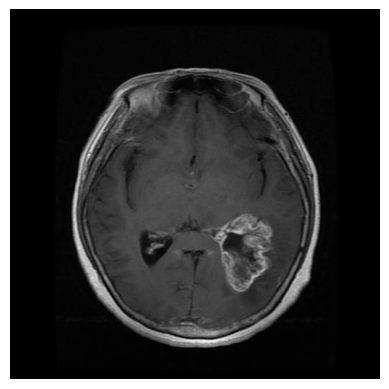

Predicted: glioma_tumor (0.8384)


In [38]:
model = model.to('cpu')
model.eval()
idx_to_labels = {idx : name for idx, name in enumerate(train_ds.classes)}

# Get test image for explanations
test_img = Image.open('./explain-samples/glioma-1.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.axis('off')
plt.show()

# Preprocess for inference and explanations
transform = T.Compose([T.Resize((img_height, img_width)), T.ToTensor()])
transform_normalize = T.Normalize(rgb_means, rgb_stds)

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) 

def predict(input_img):
    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[pred_label_idx.item()]
    print('Predicted: {} ({:.4f})'.format(predicted_label, prediction_score.squeeze().item()))
    return pred_label_idx, predicted_label

pred_label_idx, predicted_label = predict(input_img)

In [29]:
layer_gradcam = LayerGradCam(model, model.layer4[2].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

fig = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image", "blended_heat_map", "blended_heat_map", "masked_image"],
                                      ["all","positive","negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6))

try:
    mlflow.log_figure(fig[0], 'GradCAM-explanations.png')
except Exception as e: print(e)

AttributeError: 'SqueezeNet' object has no attribute 'layer4'

In [40]:
print(predicted_label)

glioma_tumor


In [49]:
def predict_squeezenet(input_img):
    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[pred_label_idx.item()]
    print('Predicted: {} ({:.4f})'.format(predicted_label, prediction_score.squeeze().item()))
    return pred_label_idx, predicted_label


In [66]:
print(model(test_images[0]))

RuntimeError: Given groups=1, weight of size [16, 128, 1, 1], expected input[1, 64, 126, 63] to have 128 channels, but got 64 channels instead

In [48]:
explainer = lime_image.LimeImageExplainer()

In [51]:
test_img.show()

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmp623_vgr3.PNG'


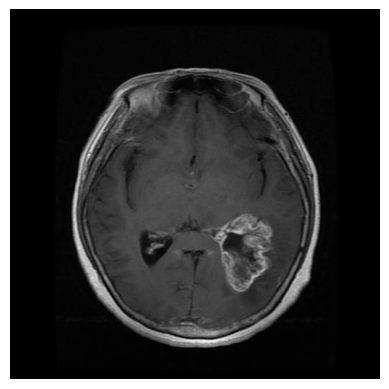

3
3


  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [61]:
# Get test image for explanations
test_img = Image.open('./explain-samples/glioma-1.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.axis('off')
plt.show()


# Preprocess for inference and explanations
transform = T.Compose([T.Resize((img_height, img_width)), T.ToTensor()])
transform_normalize = T.Normalize(rgb_means, rgb_stds)

transformed_img = transform(test_img)
input_img = transformed_img
#input_img = transform_normalize(transformed_img)

print(input_img.ndim)

#input_img = input_img.unsqueeze(0) 

print(input_img.ndim)

exp = explainer.explain_instance(test_img_data,
                                 predict_squeezenet, 
                                 top_labels=5, 
                                 hide_color=0, 
                                 num_samples=1000)

Lime attribution:   0%|          | 0/3 [00:00<?, ?it/s]

Attribution range: -0.00534947169944644 to 0.0030843853019177914


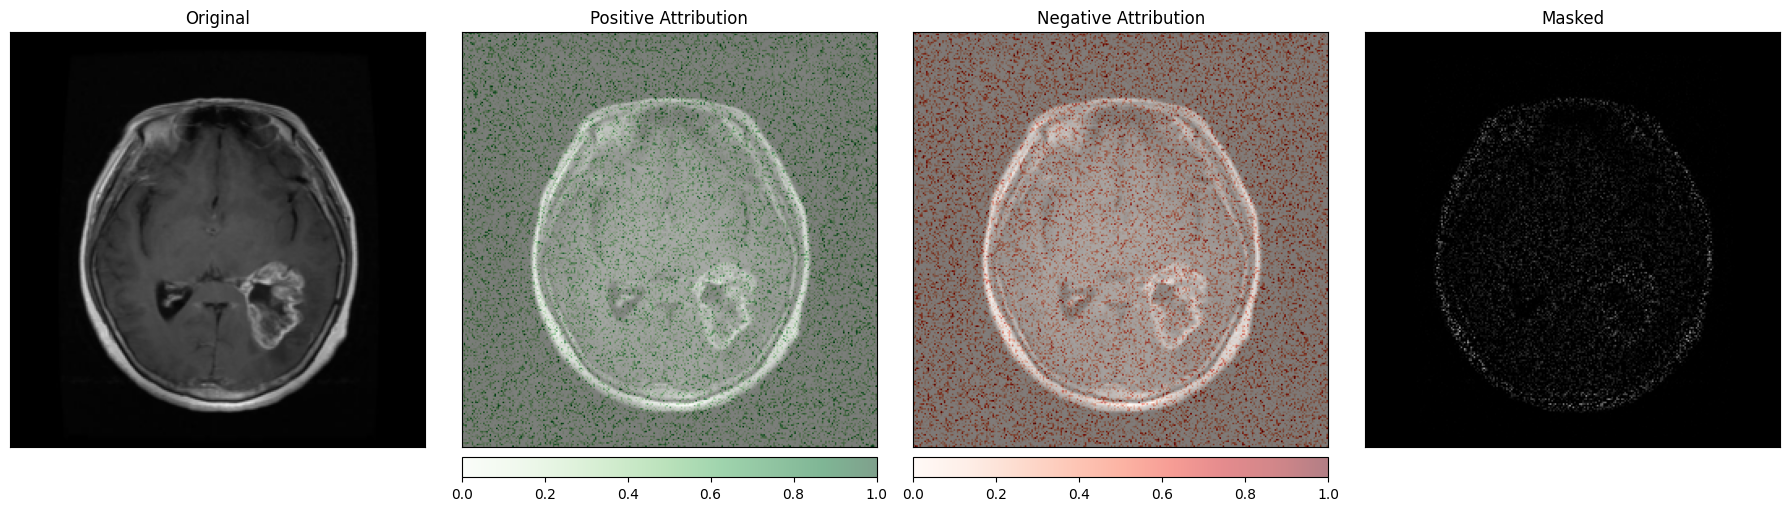

UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.8bc46ab4-ca67-4572-977b-984f1b2ea33e/LIME-explanations.png already exists.


In [41]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

lr_lime = Lime(
    model, 
    interpretable_model=SkLearnLinearRegression(),  # build-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance
)

attributions_lgc = lr_lime.attribute(input_img, target=pred_label_idx,    n_samples=40,
    perturbations_per_eval=16,
    show_progress=True
)
print('Attribution range:', attributions_lgc.min().item(), 'to', attributions_lgc.max().item())
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

fig = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image", "blended_heat_map", "blended_heat_map", "masked_image"],
                                      ["all","positive","negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6))

try:
    mlflow.log_figure(fig[0], 'LIME-explanations.png')
except Exception as e: print(e)

In [33]:
explain_folder = './explain-samples'

layer_gradcam = LayerGradCam(model, model.layer4[2].conv1)

img_ext =  ('png', 'jpg',  'tiff', 'bmp', 'gif')
images = [file for file in os.listdir(explain_folder) if file.lower().endswith(img_ext)]

for image_file in images:
    # preprocessing
    test_img = Image.open(os.path.join(explain_folder, image_file))
    transformed_img = transform(test_img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension
        
    # get prediction
    pred_label_idx, pred_label = predict(input_img)

    # get layer attribution and upsample
    attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)
    upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

    # visualize results
    _ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","blended_heat_map", "masked_image"],
                                      ["all","positive","negative", "positive"],
                                      show_colorbar=True,
                                      titles=[image_file, "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6))

AttributeError: 'SqueezeNet' object has no attribute 'layer4'

In [33]:
amlrun.upload_file('brain-tumor-classification.pth', model_path)

amlrun.register_model(model_name='brain-tumor-classification',
                   model_path='brain-tumor-classification.pth',
                   datasets = [('training', aml_dataset)],
                   model_framework=Model.Framework.PYTORCH,
                   model_framework_version=torch.__version__,
                   description='4-class brain tumor classification based on SqueezeNet',
                   tags={'area': 'healthcare', 'type': 'classification'}
                  )

record('Model registered in Azure ML')

08/01/2023 16:49 : Model registered in Azure ML


In [34]:
from mlflow import log_artifact
record('End of experiment run')
logtime = datetime.now().strftime("%d-%m-%Y-%H:%M")

try:
    mlflow.log_artifact('experiment.log')
except Exception as e: print(e)

mlflow.end_run()

08/01/2023 16:49 : End of experiment run
